Saving 2halfmoonsTrain.csv to 2halfmoonsTrain (3).csv
Early stopping at epoch 85. Best val loss: 0.001753
Test accuracy: 1.000 | Test log-loss: 0.001325


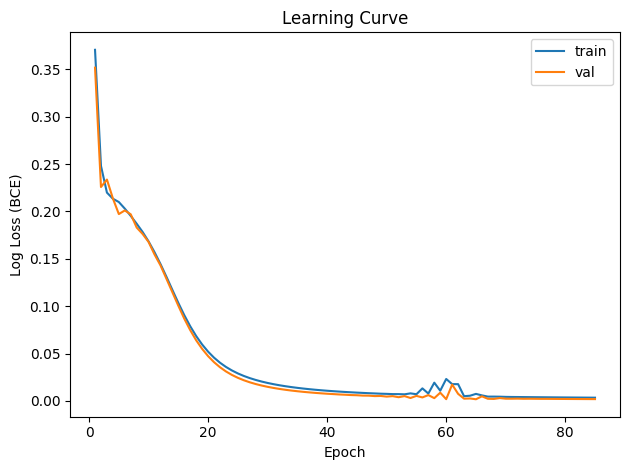

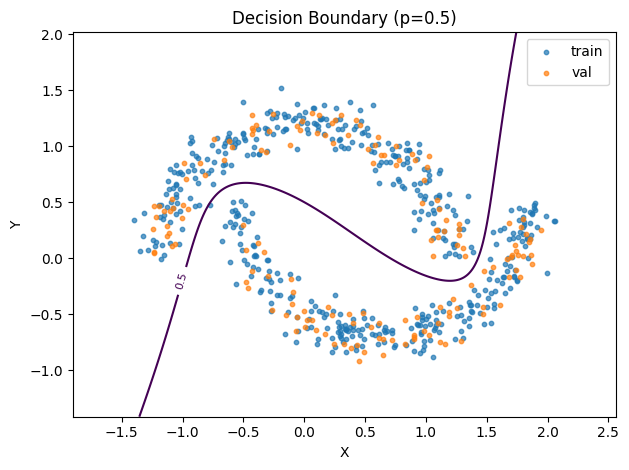

Saved: decision_boundary.png, learning_curve.png, metrics.json


In [3]:
from google.colab import files
uploaded = files.upload()  # choose your CSV

import os, io, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score

# Locate the uploaded CSV
csv_files = [fn for fn in uploaded.keys() if fn.lower().endswith(".csv")]
assert len(csv_files) == 1, "Please upload exactly one CSV file."
csv_path = csv_files[0]


df = pd.read_csv(csv_path)
assert {"X","Y","ClassLabel"}.issubset(df.columns), "CSV must have columns X, Y, ClassLabel"
X = df[["X","Y"]].to_numpy(dtype=float)
y = df["ClassLabel"].astype(int).to_numpy()
# Map labels to {0,1} robustly (works for {1,2})
y = y - y.min()

# Split: 60/20/20 (train/val/test), stratified
X_tr, X_temp, y_tr, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_te,   y_val, y_te = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize using training statistics only
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)
X_te_s  = scaler.transform(X_te)

# Define MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(16,16),
    activation="tanh",
    solver="adam",
    alpha=1e-4,                # L2 weight decay
    batch_size=64,
    learning_rate_init=1e-2,
    max_iter=1,
    warm_start=True,
    random_state=42
)

# Train with early stopping and record learning curves
epochs   = 300
patience = 20
best_val = np.inf
best_state = None
bad_epochs = 0

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []
classes = np.array([0,1])

for epoch in range(1, epochs+1):
    if epoch == 1:
        mlp.partial_fit(X_tr_s, y_tr, classes=classes)
    else:
        mlp.partial_fit(X_tr_s, y_tr)

    # Metrics
    p_tr = mlp.predict_proba(X_tr_s)
    p_v  = mlp.predict_proba(X_val_s)

    tl = log_loss(y_tr, p_tr); train_losses.append(tl)
    vl = log_loss(y_val, p_v); val_losses.append(vl)

    ta = accuracy_score(y_tr, (p_tr[:,1] >= 0.5).astype(int)); train_accs.append(ta)
    va = accuracy_score(y_val, (p_v[:,1]  >= 0.5).astype(int)); val_accs.append(va)

    if vl < best_val - 1e-6:
        best_val = vl
        best_state = (mlp.coefs_, mlp.intercepts_)
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            if best_state is not None:
                mlp.coefs_, mlp.intercepts_ = best_state
            print(f"Early stopping at epoch {epoch}. Best val loss: {best_val:.4g}")
            break

# Test set evaluation
from sklearn.metrics import accuracy_score
p_te = mlp.predict_proba(X_te_s)
test_acc = accuracy_score(y_te, (p_te[:,1] >= 0.5).astype(int))
test_logloss = log_loss(y_te, p_te)
print(f"Test accuracy: {test_acc:.3f} | Test log-loss: {test_logloss:.4g}")

# Plot learning curve
plt.figure()
plt.plot(range(1,len(train_losses)+1), train_losses, label="train")
plt.plot(range(1,len(val_losses)+1),   val_losses,   label="val")
plt.xlabel("Epoch"); plt.ylabel("Log Loss (BCE)")
plt.title("Learning Curve")
plt.legend(); plt.tight_layout()
plt.savefig("learning_curve.png", dpi=160)
plt.show()

# Decision boundary (p=0.5)
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 400),
                     np.linspace(x2_min, x2_max, 400))
grid   = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)
probs  = mlp.predict_proba(scaler.transform(grid))[:,1].reshape(xx.shape)

plt.figure()
cs = plt.contour(xx, yy, probs, levels=[0.5])
plt.clabel(cs, inline=True, fontsize=8)
plt.scatter(X_tr[:,0], X_tr[:,1], s=10, alpha=0.7, label="train")
plt.scatter(X_val[:,0], X_val[:,1], s=10, alpha=0.7, label="val")
plt.xlabel("X"); plt.ylabel("Y"); plt.title("Decision Boundary (p=0.5)")
plt.legend(); plt.tight_layout()
plt.savefig("decision_boundary.png", dpi=160)
plt.show()

# Save metrics for your report
metrics = {
    "epochs_trained": len(train_losses),
    "best_val_log_loss": float(best_val),
    "test_log_loss": float(test_logloss),
    "test_accuracy": float(test_acc),
    "train_accuracy": float(train_accs[-1]),
    "val_accuracy": float(val_accs[-1]),
    "hidden_layers": [16,16],
    "activation": "tanh",
    "learning_rate_init": 1e-2,
    "batch_size": 64,
    "weight_decay_alpha": 1e-4,
    "patience": patience,
}
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved: decision_boundary.png, learning_curve.png, metrics.json")
# (Use the Files pane in the left sidebar to download these.)
